In [1]:
import brainio

raw_assembly = brainio.get_assembly('dicarlo.muri1320.2023.v1.pico.psth.raw')
print(raw_assembly)

Loading catalog from entrypoints
Loading lookup from /braintree/home/msch/miniconda3/envs/pipeline_analysis/lib/python3.11/site-packages/brainio_dicarlo/lookup.csv
<xarray.NeuronRecordingAssembly 'data' (presentation: 40127, neuroid: 192,
                                        time_bin: 10)>
array([[[0, 0, 0, ..., 0, 2, 1],
        [0, 0, 0, ..., 1, 2, 0],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [1, 0, 1, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 1, 0]],

       [[1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 1],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 1, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [1, 4, 3, ..., 1, 1, 1]],

       [[4, 1, 3, ..., 1, 0, 0],
        [2, 0, 3, ..., 0, 0, 0],
        [2, 0, 2, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]],

       [[0, 5, 0, ..., 0, 2, 0],
        [0, 0, 0,

In [2]:
import numpy as np

print(f"unique images: {len(set(raw_assembly['stimulus_id'].values))}")
print("repetitions:", np.unique(raw_assembly['repetition'].values, return_counts=True))
print()
print(f"electrodes: {len(raw_assembly['neuroid'])}")
print(f"regions: {sorted(set(raw_assembly['region'].values))}")
print(f"subregions: {sorted(set(raw_assembly['subregion'].values))}")
print()
print(f"time bins: {list(zip(raw_assembly['time_bin_start_ms'].values, raw_assembly['time_bin_stop_ms'].values))}")

unique images: 1318
repetitions: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17]), array([11532,  7921,  5284,  5272,  3956,  2168,  1324,  1324,  1319,
          10,     3,     2,     2,     2,     2,     2,     2,     2]))

electrodes: 192
regions: ['IT']
subregions: ['aIT', 'pIT']

time bins: [(70, 80), (80, 90), (90, 100), (100, 110), (110, 120), (120, 130), (130, 140), (140, 150), (150, 160), (160, 170)]


## filter neuroids

In [3]:
from pipeline_analysis.internal_consistency import plot_internal_consistency_over_time, internal_consistency

# compute per-neuroid consistency when averaging out time
assembly = raw_assembly[{'time_bin': [70 <= start <= 170 for start in raw_assembly['time_bin_start_ms'].values]}]
assembly = assembly.mean('time_bin')
consistencies = internal_consistency(assembly)
consistencies = consistencies.groupby('neuroid_id').mean().reset_index()

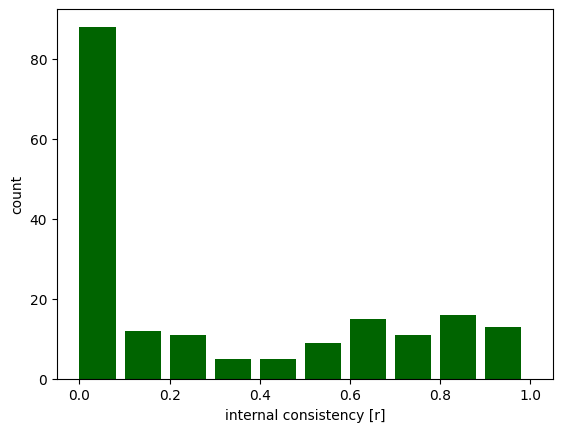

In [4]:
from matplotlib import pyplot

fig, ax = pyplot.subplots()
ax.hist(consistencies['correlation'], bins=np.arange(0, 1.1, .1), width=0.08, color='darkgreen')
ax.set_xlabel('internal consistency [r]')
ax.set_ylabel('count')
fig.show()

plot cumulative

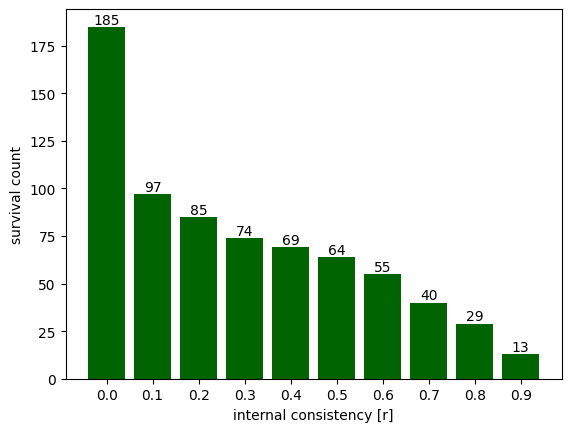

In [5]:
import numpy as np
from matplotlib import pyplot

histogram_base = np.arange(0, 1.1, .1)
histogram_values, histogram_base = np.histogram(consistencies['correlation'], bins=histogram_base)
cumulative = np.cumsum(histogram_values[::-1])[::-1]
# plot the cumulative function
fig, ax = pyplot.subplots()
x, y = histogram_base[:-1], cumulative
ax.bar(x, y, width=0.08, color='darkgreen')
for _x, _y in zip(x, y):
    ax.text(_x, _y, _y, ha='center', va='bottom')
ax.set_xlabel('internal consistency [r]')
ax.set_ylabel('survival count')
ax.set_xticks(histogram_base[:-1])
fig.show()

In [6]:
# filter assembly
CONSISTENCY_THRESHOLD = 0.7
good_neuroids = consistencies['neuroid_id'][consistencies['correlation'] > CONSISTENCY_THRESHOLD]
good_neuroids = good_neuroids.values
print(f"{len(good_neuroids)} good neuroids > {CONSISTENCY_THRESHOLD}: {good_neuroids}")
filtered_assembly = raw_assembly[{'neuroid': [neuroid_id in good_neuroids
                                              for neuroid_id in raw_assembly['neuroid_id'].values]}]

40 good neuroids > 0.7: ['A-007' 'A-008' 'A-023' 'B-016' 'B-017' 'B-019' 'B-020' 'B-021' 'B-022'
 'B-023' 'C-001' 'C-002' 'C-003' 'C-004' 'C-008' 'C-012' 'C-013' 'C-014'
 'C-015' 'C-016' 'C-024' 'D-001' 'D-003' 'D-004' 'D-005' 'D-006' 'D-007'
 'D-008' 'D-009' 'D-010' 'D-013' 'D-030' 'D-031' 'E-005' 'E-006' 'E-007'
 'E-008' 'E-009' 'F-007' 'F-008']


plot consistencies over time

time_bin: 100%|██████████| 10/10 [03:25<00:00, 20.56s/it]


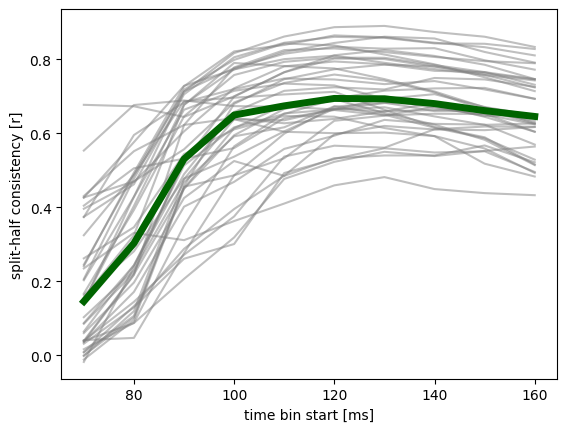

In [7]:
fig = plot_internal_consistency_over_time(filtered_assembly)
fig.show()

## average out repetitions and time

In [8]:
from pipeline_analysis.internal_consistency import average_repetitions

assembly = average_repetitions(raw_assembly)
assembly = assembly[{'time_bin': [70 <= start <= 170 for start in assembly['time_bin_start_ms'].values]}]
assembly = assembly.mean('time_bin')
print(assembly)

<xarray.NeuronRecordingAssembly 'data' (presentation: 1320, neuroid: 192)>
array([[0.74333333, 0.57333333, 0.44333333, ..., 0.93666667, 0.84      ,
        0.56      ],
       [0.44827586, 0.33793103, 0.28965517, ..., 0.63448276, 0.6137931 ,
        0.51724138],
       [0.384375  , 0.265625  , 0.259375  , ..., 0.371875  , 0.378125  ,
        0.309375  ],
       ...,
       [0.39032258, 0.28064516, 0.22580645, ..., 0.39354839, 0.38709677,
        0.33225806],
       [0.48064516, 0.34193548, 0.39677419, ..., 0.50645161, 0.50967742,
        0.37419355],
       [0.27741935, 0.16129032, 0.22903226, ..., 0.31935484, 0.31935484,
        0.23548387]])
Coordinates:
  * neuroid                        (neuroid) MultiIndex
  - filter_high                    (neuroid) int64 6000 6000 6000 ... 6000 6000
  - adapter_version                (neuroid) object 'adaptorAIT.v1.2023' ... ...
  - array                          (neuroid) object '6250-002929' ... '6250-0...
  - monkey_directory               (n

## Readout capability

num sites: 100%|██████████| 7/7 [00:17<00:00,  2.53s/it]


   num_sites      mean       std
0          1  0.522272  0.031662
1          5  0.531295  0.050898
2         10  0.559023  0.040092
3         20  0.546441  0.039213
4         40  0.549755  0.040755
5         80  0.519663  0.050275
6        160  0.525347  0.049175


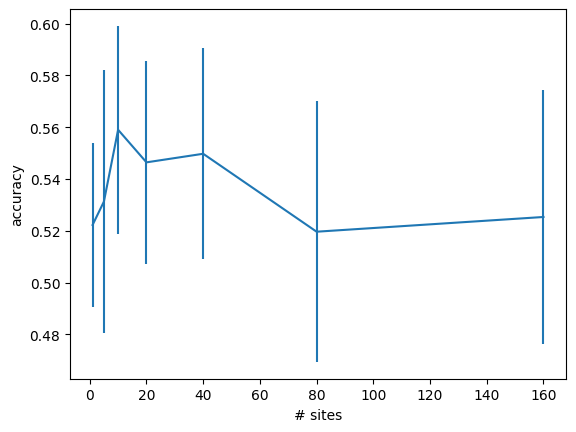

In [9]:
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from numpy.random import RandomState
from sklearn.linear_model import RidgeClassifierCV
import pandas as pd
from tqdm import tqdm

results = []

random_state = RandomState(0)
for num_sites in tqdm([1, 5, 10, 20, 40, 80, 160], desc='num sites'):
    for split in range(10):
        sites = random_state.choice(assembly['neuroid_id'].values, size=num_sites, replace=False)
        sites_assembly = assembly[{'neuroid': [neuroid_id in sites for neuroid_id in assembly['neuroid_id'].values]}]
        # train/test
        stimulus_ids = assembly['stimulus_id'].values
        train_stimuli, test_stimuli = train_test_split(stimulus_ids, test_size=0.1, random_state=random_state)
        train_assembly = assembly[{'presentation': [stimulus_id in train_stimuli
                                                    for stimulus_id in assembly['stimulus_id'].values]}]
        test_assembly = assembly[{'presentation': [stimulus_id in test_stimuli
                                                   for stimulus_id in assembly['stimulus_id'].values]}]
        # run classifier
        classifier = RidgeClassifierCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10], fit_intercept=True)
        classifier.fit(train_assembly, train_assembly['image_label'])
        test_score = classifier.score(test_assembly, test_assembly['image_label'])
        results.append({'num_sites': num_sites, 'split': split, 'test_score': test_score})
results = pd.DataFrame(results)
results = results.groupby('num_sites') \
    .agg(mean=('test_score', np.mean), std=('test_score', np.std)) \
    .reset_index()
print(results)

fig, ax = pyplot.subplots()
ax.errorbar(results['num_sites'], results['mean'], yerr=results['std'])
ax.set_xlabel('# sites')
ax.set_ylabel('accuracy')
fig.show()